In [ ]:
#%% Setting Up
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import xarray as xr
# import xesmf as xe
import networkx as nx
# import rioxarray as rxr

import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from shapely.geometry import Point
from shapely.geometry import Polygon

import glob
import os
import itertools
import tqdm
import gc
import time
import pickle

from joblib import Parallel, delayed

import torch

import configparser
cfg = configparser.ConfigParser()
cfg.optionxform = str
cfg.read('/home/sarth/rootdir/datadir/assets/defaults.ini')
cfg = {s: dict(cfg.items(s)) for s in cfg.sections()}
PATHS = cfg['PATHS']

print("Setting up...")

In [ ]:
from scipy import stats, signal

def _mask_valid(pred, true):
    mask = ~np.isnan(true) & ~np.isnan(pred)
    pred = pred[mask]
    true = true[mask]
    pred[pred < 0] = 0
    true[true < 0] = 0
    return pred, true

def RMSE(pred, true):
    pred, true = _mask_valid(pred, true)
    return np.sqrt(np.mean((true - pred)**2))

def pearsonr(pred, true):
    pred, true = _mask_valid(pred, true)
    r, _ = stats.pearsonr(true, pred)
    return r

def NSE(pred, true):
    pred, true = _mask_valid(pred, true)
    return 1 - np.sum((true - pred)**2) / np.sum((true - np.mean(true))**2)

def KGE(pred, true):
    pred, true = _mask_valid(pred, true)
    r = pearsonr(pred, true)
    alpha = np.std(pred) / np.std(true)
    beta = np.mean(pred) / np.mean(true)
    return 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)

def PBIAS(pred, true):
    pred, true = _mask_valid(pred, true)
    return np.sum(true - pred) / np.sum(true) * 100

def alpha_NSE(pred, true):
    pred, true = _mask_valid(pred, true)
    return np.std(pred) / np.std(true)

def beta_NSE(pred, true):
    pred, true = _mask_valid(pred, true)
    return (np.mean(pred) - np.mean(true)) / np.std(true)

def _get_fdc(data):
    data = np.sort(data)[::-1]
    return data

def fdc_fms(pred, true, lower = 0.2, upper = 0.7):
    pred, true = _mask_valid(pred, true)

    sim = _get_fdc(pred)
    obs = _get_fdc(true)
    sim[sim <= 0] = 1e-6
    obs[obs <= 0] = 1e-6

    qsm_lower = np.log(sim[np.round(lower * len(sim)).astype(int)])
    qsm_upper = np.log(sim[np.round(upper * len(sim)).astype(int)])
    qom_lower = np.log(obs[np.round(lower * len(obs)).astype(int)])
    qom_upper = np.log(obs[np.round(upper * len(obs)).astype(int)])

    fms = ((qsm_lower - qsm_upper) - (qom_lower - qom_upper)) / (qom_lower - qom_upper + 1e-6)

    return fms * 100

def fdc_fhv(pred, true, h = 0.02):
    pred, true = _mask_valid(pred, true)

    sim = _get_fdc(pred)
    obs = _get_fdc(true)

    obs = obs[:np.round(h * len(obs)).astype(int)]
    sim = sim[:np.round(h * len(sim)).astype(int)]

    fhv = np.sum(sim - obs) / np.sum(obs)

    return fhv * 100

def fdc_flv(pred, true, l = 0.3):
    pred, true = _mask_valid(pred, true)

    sim = _get_fdc(pred)
    obs = _get_fdc(true)
    sim[sim <= 0] = 1e-6
    obs[obs <= 0] = 1e-6

    obs = obs[-np.round(l * len(obs)).astype(int):]
    sim = sim[-np.round(l * len(sim)).astype(int):]

    # transform values to log scale
    obs = np.log(obs)
    sim = np.log(sim)

    # calculate flv part by part
    qsl = np.sum(sim - sim.min())
    qol = np.sum(obs - obs.min())

    flv = -1 * (qsl - qol) / (qol + 1e-6)

    return flv * 100

def mean_peak_timing(pred, true, window = 3):
    pred, true = _mask_valid(pred, true)

    peaks, _ = signal.find_peaks(true, distance=2*window, prominence=np.std(true))

    # pred_idx_lst = []
    timing_error_lst = []
    for idx in peaks:
        if (pred[idx] > pred[idx - 1]) and (pred[idx] > pred[idx + 1]):
            peak_pred = pred[idx]
            peak_pred_idx = idx
        else:
            peak_pred_idx = np.argmax(pred[max(idx - window,0):idx + window + 1]) + max(idx - window,0)
            peak_pred = pred[peak_pred_idx]
        # pred_idx_lst.append(peak_pred_idx)
    
        peak_true = true[idx]
        timing_error = np.abs(peak_pred_idx - idx) 
        timing_error_lst.append(timing_error)
    
    mean_timing_error = np.mean(timing_error_lst) if len(timing_error_lst) > 0 else np.nan

    return mean_timing_error

def missed_peaks(pred, true, window = 3, threshold = 80):
    pred, true = _mask_valid(pred, true)

    peaks_obs_times, _ = signal.find_peaks(true, distance=2*window, height = np.percentile(true, threshold))
    peaks_sim_times, _ = signal.find_peaks(pred, distance=2*window, height = np.percentile(pred, threshold))
    
    missed_events = 0
    for idx in peaks_obs_times:
        nearby_peak_sim_index = np.where(np.abs(peaks_sim_times - idx) <= window)[0]
        if len(nearby_peak_sim_index) == 0:
            missed_events += 1
            # print(idx)
    
    missed_peak_values = (missed_events / len(peaks_obs_times)) * 100 if len(peaks_obs_times) > 0 else np.nan

    return missed_peak_values

def F1_score_of_capturing_peaks(pred, true, window = 3, threshold = 80):
    pred, true = _mask_valid(pred, true)

    peaks_obs_times, _ = signal.find_peaks(true, distance=2*window, height = np.percentile(true, threshold))
    peaks_sim_times, _ = signal.find_peaks(pred, distance=2*window, height = np.percentile(pred, threshold))
    
    true_positive_peaks = 0 # peak in obs and nearby in sim
    true_negative_peaks = 0 # no peak in obs and sim
    false_positive_peaks = 0 # peak in sim but not nearby in obs
    false_negative_peaks = 0 # peak in obs but not nearby in sim

    for idx in peaks_obs_times:
        nearby_peak_sim_index = np.where(np.abs(peaks_sim_times - idx) <= window)[0]
        if len(nearby_peak_sim_index) > 0:
            true_positive_peaks += 1
        else:
            false_negative_peaks += 1
    
    for idx in peaks_sim_times:
        nearby_peak_obs_index = np.where(np.abs(peaks_obs_times - idx) <= window)[0]
        if len(nearby_peak_obs_index) == 0:
            false_positive_peaks += 1

    precision = true_positive_peaks / (true_positive_peaks + false_positive_peaks) if (true_positive_peaks + false_positive_peaks) > 0 else np.nan
    recall = true_positive_peaks / (true_positive_peaks + false_negative_peaks) if (true_positive_peaks + false_negative_peaks) > 0 else np.nan
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else np.nan

    return f1_score

In [ ]:
import numpy as np
import xarray as xr

def compute_metrics_ds(y_pred, y_true):
    """
    Compute a set of metrics for each lead time and catchment.
    y_pred and y_true: numpy arrays of shape (time_idx, lead_time, catmt_idx)
    
    Returns:
      xr.Dataset with dims ("time_idx", "lead_time", "catmt_idx") and variables:
          - RMSE, PearsonR, NSE, KGE, PBIAS, alpha_NSE, beta_NSE,
            FDC_FMS, FDC_FHV, FDC_FLV, mean_peak_timing, missed_peaks, F1_score
          - Also includes raw y_pred and y_true.
    """

    time_steps, num_leadtimes, num_catmt = y_pred.shape

    # Prepare arrays to hold computed metrics [lead_time, catmt_idx]
    rmse_arr            = np.empty((num_leadtimes, num_catmt))
    pearson_arr         = np.empty((num_leadtimes, num_catmt))
    nse_arr             = np.empty((num_leadtimes, num_catmt))
    kge_arr             = np.empty((num_leadtimes, num_catmt))
    pbias_arr           = np.empty((num_leadtimes, num_catmt))
    alpha_nse_arr       = np.empty((num_leadtimes, num_catmt))
    beta_nse_arr        = np.empty((num_leadtimes, num_catmt))
    fdc_fms_arr         = np.empty((num_leadtimes, num_catmt))
    fdc_fhv_arr         = np.empty((num_leadtimes, num_catmt))
    fdc_flv_arr         = np.empty((num_leadtimes, num_catmt))
    mean_peak_timing_arr= np.empty((num_leadtimes, num_catmt))
    missed_peaks_arr    = np.empty((num_leadtimes, num_catmt))
    f1_score_arr        = np.empty((num_leadtimes, num_catmt))

    # Loop over lead times and catchments, computing metrics from the time series
    for lt in range(num_leadtimes):
        for cat in range(num_catmt):
            pred = y_pred[:, lt, cat]
            true = y_true[:, lt, cat]
            rmse_arr[lt, cat]             = RMSE(pred, true)
            pearson_arr[lt, cat]          = pearsonr(pred, true)
            nse_arr[lt, cat]              = NSE(pred, true)
            kge_arr[lt, cat]              = KGE(pred, true)
            pbias_arr[lt, cat]            = PBIAS(pred, true)
            alpha_nse_arr[lt, cat]        = alpha_NSE(pred, true)
            beta_nse_arr[lt, cat]         = beta_NSE(pred, true)
            fdc_fms_arr[lt, cat]          = fdc_fms(pred, true)
            fdc_fhv_arr[lt, cat]          = fdc_fhv(pred, true)
            fdc_flv_arr[lt, cat]          = fdc_flv(pred, true)
            mean_peak_timing_arr[lt, cat] = mean_peak_timing(pred, true)
            missed_peaks_arr[lt, cat]     = missed_peaks(pred, true)
            f1_score_arr[lt, cat]         = F1_score_of_capturing_peaks(pred, true)

    # Create coordinates
    lead_times = np.arange(num_leadtimes)
    catmt_idx  = np.arange(num_catmt)
    time_idx   = np.arange(time_steps)

    ds = xr.Dataset(
        {
            "RMSE":             (("lead_time", "catmt_idx"), rmse_arr),
            "PearsonR":         (("lead_time", "catmt_idx"), pearson_arr),
            "NSE":              (("lead_time", "catmt_idx"), nse_arr),
            "KGE":              (("lead_time", "catmt_idx"), kge_arr),
            "PBIAS":            (("lead_time", "catmt_idx"), pbias_arr),
            "alpha_NSE":        (("lead_time", "catmt_idx"), alpha_nse_arr),
            "beta_NSE":         (("lead_time", "catmt_idx"), beta_nse_arr),
            "FDC_FMS":          (("lead_time", "catmt_idx"), fdc_fms_arr),
            "FDC_FHV":          (("lead_time", "catmt_idx"), fdc_fhv_arr),
            "FDC_FLV":          (("lead_time", "catmt_idx"), fdc_flv_arr),
            "mean_peak_timing": (("lead_time", "catmt_idx"), mean_peak_timing_arr),
            "missed_peaks":     (("lead_time", "catmt_idx"), missed_peaks_arr),
            "F1_score":         (("lead_time", "catmt_idx"), f1_score_arr),
            "y_pred":           (("time_idx", "lead_time", "catmt_idx"), y_pred),
            "y_true":           (("time_idx", "lead_time", "catmt_idx"), y_true)
        },
        coords={
            "time_idx": time_idx,
            "lead_time": lead_times,
            "catmt_idx": catmt_idx
        }
    )
    
    return ds

# # Example usage:
# metrics_ds = compute_metrics_ds(y_pred, y_true)
# metrics_ds

# Calculate Metrics

In [ ]:
filepath = lambda x, region: os.path.join('/home/sarth/rootdir/workdir/projects/Paper_Data_Latency/Revised_Figure03', f'v{x}_surr_{region}_test.pt')

version = 1
region = 'camelsus'

saved_tensor = torch.load(filepath(version, region))

for key in saved_tensor.keys():
    print(key, saved_tensor[key].shape)

y_pred = saved_tensor['pred_tensor'].numpy()
y_true = saved_tensor['true_tensor'].numpy()

metrics = compute_metrics_ds(y_pred, y_true)
metrics.to_netcdf(filepath(version, region).replace('.pt', '_metrics.nc'))
metrics

In [ ]:
version = 1
region = 'camelsus'
for version in [1, 2, 3, 4]:
    for region in ['camelsus', 'camelsind', 'hysets']: 
        if os.path.exists(filepath(version, region).replace('.pt', '_metrics.nc')):
            print(f"Skipping version {version}, region {region}")
        else:
            print(f"Processing version {version}, region {region}")
            saved_tensor = torch.load(filepath(version, region))
            # for key in saved_tensor.keys():
            #     print(key, saved_tensor[key].shape)
            y_pred = saved_tensor['pred_tensor'].numpy()
            y_true = saved_tensor['true_tensor'].numpy()
            metrics = compute_metrics_ds(y_pred, y_true)
            metrics.to_netcdf(filepath(version, region).replace('.pt', '_metrics.nc'))

# Helper Functions

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

def plot_metric_performance(metric_name, ds, lead_time=1, cmap_name='viridis', min_max=None, watersheds_local=None, camels_graph_local=None):
    """
    Plot regional performance based on a metric and gauge-level performance.

    Parameters:
      metric_name: str, name of the metric in ds (expected dims: [lead_time, catmt_idx])
      ds: xarray.Dataset containing the metric array
      lead_time: int, which lead time to use (default: 1 corresponds to the first lead time)
      cmap_name: str, name of the colormap (default: 'viridis')
      min_max: list [vmin, vmax] to fix the colormap range; if None, get min and max from combined data.
    """
    # Select the metric values for the desired lead time (assume 1-indexed)
    metric_vals = ds[metric_name].isel(lead_time=lead_time-1).values  # shape: (catmt_idx,)
    gauge_metric = metric_vals  # already 1-D for selected lead time

    # Append selected metric to camels_graph (assuming order matches ds catmt_idx)
    # camels_graph_local = catmt_graph.copy()
    camels_graph_local['metric'] = gauge_metric

    # Compute regional median per watershed (using huc_02 field)
    region_median = camels_graph_local.groupby('huc_02')['metric'].median()
    # Merge with all_watersheds: assume all_watersheds has column "huc_02" 
    # watersheds_local = all_watersheds.copy()
    watersheds_local['region_metric'] = watersheds_local['huc_02'].map(region_median)
    
    # Determine vmin, vmax for normalization
    if min_max is None:
        all_values = np.concatenate([watersheds_local['region_metric'].dropna().values,
                                     camels_graph_local['metric'].values])
        vmin, vmax = np.nanmin(all_values), np.nanmax(all_values)
    else:
        vmin, vmax = min_max

    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 12), dpi=600)

    # Plot regions (all_watersheds) with fill based on regional median
    watersheds_local.plot(
        column='region_metric',
        ax=ax,
        cmap=cmap_name,
        norm=norm,
        edgecolor='gray',
        linewidth=0.5,
        alpha=0.70,
        legend=False  # add colorbar separately
    )
    
    # Scatter plot for gauge locations: use the gauge metric to set facecolor
    scatter = ax.scatter(
        camels_graph_local['gauge_lon'],
        camels_graph_local['gauge_lat'],
        c=camels_graph_local['metric'],
        cmap=cmap_name,
        norm=norm,
        edgecolor='black',
        linewidth=0.3,
        s=30,
        marker='^',
        alpha=0.70
    )
    
    # Add a clean colorbar
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])  # required for matplotlib < 3.1
    if 'NSE' in metric_name:
        cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0, shrink=0.75, extend='min', aspect=50)
    else:
        cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0, shrink=0.75, aspect=50)
    if 'F1' in metric_name:
        metric_name = 'F1 score of peaks captured'
    cbar.set_label(metric_name, fontsize=32)
    cbar.ax.tick_params(labelsize=24, rotation=45)
    
    # Aesthetics
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    plt.tight_layout()
    return fig, ax#, (camels_graph_local, region_median, watersheds_local)

# Example usage:
# fig, ax = plot_metric_performance('NSE', metrics_v1, lead_time=1, cmap_name='plasma', min_max=None)
# plt.show()

# CAMELS-US

In [ ]:
#%% Region-Specific: CAMELS-US
DIRNAME = '03min_GloFAS_CAMELS-US'
SAVE_PATH = os.path.join(PATHS['devp_datasets'], DIRNAME)
resolution = 0.05
lon_360_180 = lambda x: (x + 180) % 360 - 180 # convert 0-360 to -180-180
lon_180_360 = lambda x: x % 360 # convert -180-180 to 0-360
region_bounds = {
    'minx': -130,
    'miny': 20,
    'maxx': -65,
    'maxy': 50
}
camels_attributes_graph = pd.read_csv(os.path.join(SAVE_PATH, 'graph_attributes.csv'), index_col=0)
camels_attributes_graph.index = camels_attributes_graph.index.map(lambda x: str(x).zfill(8))
camels_attributes_graph['huc_02'] = camels_attributes_graph['huc_02'].map(lambda x: str(x).zfill(2))
camels_graph = camels_attributes_graph.copy()
camels_graph = camels_graph[camels_graph['area_percent_difference'] < 10]
camels_graph = camels_graph[camels_graph['num_nodes'] > 1]
print(f"Number of CAMELS-US catmt's: {len(camels_graph)}")
del camels_attributes_graph

region_shp = gpd.read_file(os.path.join(PATHS['watershed-boundary-dataset'], 'huc02', 'shapefile.shp'), crs = 'epsg:4326')
all_watersheds = region_shp.copy()
all_watersheds = all_watersheds.rename(columns={'huc2': 'watershed'})
all_watersheds['huc_02'] = all_watersheds['watershed'].map(lambda x: x.split('_')[0])

temp = gpd.read_file(os.path.join(PATHS['CAMELS'], 'CAMELS-US', 'HCDN_nhru_final_671.shp'), crs = 'epsg:4326')
temp = temp[['hru_id', 'geometry']]
temp['hru_id'] = temp['hru_id'].map(lambda x: str(x).zfill(8))
temp = temp.set_index('hru_id')

all_catchments = camels_graph.merge(temp, left_index=True, right_index=True, how='left')
all_catchments = all_catchments[['huc_02', 'gauge_lon', 'gauge_lat', 'area_geospa_fabric', 'geometry', 'snapped_lon', 'snapped_lat']]
all_catchments = gpd.GeoDataFrame(all_catchments, crs='epsg:4326', geometry='geometry')
all_catchments = all_catchments.reset_index()
del temp

catmt_graph = camels_graph.copy()

In [ ]:
filepath = lambda x, region: os.path.join('/home/sarth/rootdir/workdir/projects/Paper_Data_Latency/Revised_Figure03', f'v{x}_surr_{region}_test_metrics.nc')
ds = xr.open_dataset(filepath(2, 'camelsus'))

fig, ax = plot_metric_performance('NSE', ds, lead_time=1, cmap_name='RdYlBu', min_max=[-1,1], watersheds_local=all_watersheds, camels_graph_local=catmt_graph)
plt.show()

In [ ]:
fig, ax = plot_metric_performance('F1_score', ds, lead_time=1, cmap_name='RdYlBu', min_max=[0,1], watersheds_local=all_watersheds, camels_graph_local=catmt_graph)
plt.show()

# CAMELS-IND

In [171]:
#%% Region-Specific: CAMELS-IND
DIRNAME = '03min_GloFAS_CAMELS-IND'
SAVE_PATH = os.path.join(PATHS['devp_datasets'], DIRNAME)
resolution = 0.05
lon_360_180 = lambda x: (x + 180) % 360 - 180 # convert 0-360 to -180-180
lon_180_360 = lambda x: x % 360 # convert -180-180 to 0-360
region_bounds = {
    'minx': 66,
    'miny': 5,
    'maxx': 100,
    'maxy': 30
}
camels_attributes_graph = pd.read_csv(os.path.join(SAVE_PATH, 'graph_attributes.csv'), index_col=0)
camels_attributes_graph.index = camels_attributes_graph.index.map(lambda x: str(x).zfill(5))
camels_attributes_graph['huc_02'] = camels_attributes_graph['huc_02'].map(lambda x: str(x).zfill(2))
camels_graph = camels_attributes_graph.copy()
camels_graph = camels_graph[camels_graph['ghi_area'] <= 30000]
camels_graph = camels_graph[camels_graph['area_percent_difference'] < 10]
camels_graph = camels_graph[camels_graph['num_nodes'] > 1]
camels_graph = camels_graph.rename(columns = {'ghi_lon': 'gauge_lon', 'ghi_lat': 'gauge_lat'})
print(f"Number of catmt's: {len(camels_graph)}")
del camels_attributes_graph

all_watershed_names = sorted(glob.glob(os.path.join(PATHS['CAMELS'], 'CAMELS-IND', 'CAMELS_IND_All_Catchments', 'shapefiles_catchment', '*')))
all_watershed_names = [x for x in all_watershed_names if os.path.isdir(x) and os.path.basename(x) != 'merged']
all_watershed_shps = [os.path.join(x, os.path.basename(x) + '.shp') for x in all_watershed_names]
all_watershed_shps = [gpd.read_file(x) for x in all_watershed_shps]
all_watersheds = gpd.GeoDataFrame(pd.concat(all_watershed_shps, ignore_index=True))
all_watersheds = all_watersheds.to_crs(epsg=4326)
all_watersheds['watershed'] = [os.path.basename(x) for x in all_watershed_names]
all_watersheds = all_watersheds[['watershed', 'geometry']]
# all_watersheds.set_index('watershed', inplace=True)
all_watersheds['huc_02'] = all_watersheds['watershed'].map(lambda x: x.split('_')[0])
del all_watershed_shps, all_watershed_names

# Create a union of all watershed geometries
union_geom = all_watersheds['geometry'].unary_union
# Create a GeoDataFrame with a single row containing the union geometry
region_shp = gpd.GeoDataFrame({'huc_02': ['all'], 'geometry': [union_geom]},
                              crs=all_watersheds.crs)
del union_geom

all_catchments = gpd.read_file(os.path.join(PATHS['CAMELS'], 'CAMELS-IND', 'CAMELS_IND_Catchments_Streamflow_Sufficient', 'shapefiles_catchment', 'catchments.shp'))
all_catchments = all_catchments.to_crs(epsg=4326)
all_catchments['huc_02'] = all_catchments['gauge_id'].map(lambda x: x[:2])
# Merge camels_graph[['ghi_area']] with all_catchments using index of camels_graph which is gauge_id and gauge_id of all_catchments
all_catchments = all_catchments.merge(camels_graph[['ghi_area']], left_on='gauge_id', right_index=True)
all_catchments = all_catchments.sort_values(by = 'ghi_area', ascending = True).reset_index(drop = True)

catmt_graph = camels_graph.copy()

Number of catmt's: 191


In [ ]:
filepath = lambda x, region: os.path.join('/home/sarth/rootdir/workdir/projects/Paper_Data_Latency/Revised_Figure03', f'v{x}_surr_{region}_test_metrics.nc')
ds = xr.open_dataset(filepath(2, 'camelsind'))

fig, ax = plot_metric_performance('NSE', ds, lead_time=1, cmap_name='RdYlBu', min_max=[-1,1], watersheds_local=all_watersheds, camels_graph_local=catmt_graph)
plt.show()

In [ ]:
fig, ax = plot_metric_performance('F1_score', ds, lead_time=1, cmap_name='RdYlBu', min_max=[0,1], watersheds_local=all_watersheds, camels_graph_local=catmt_graph)
plt.show()

# HYSETS

In [168]:
#%% Region-Specific: hysets
DIRNAME = '03min_GloFAS_hysets'
SAVE_PATH = os.path.join(PATHS['devp_datasets'], DIRNAME)
resolution = 0.05
lon_360_180 = lambda x: (x + 180) % 360 - 180 # convert 0-360 to -180-180
lon_180_360 = lambda x: x % 360 # convert -180-180 to 0-360
region_bounds = {
    'minx': -130,
    'miny': 20,
    'maxx': -65,
    'maxy': 50
}

catmt_graph = pd.read_csv(os.path.join(SAVE_PATH, 'nested_gauges', 'graph_attributes_with_nesting.csv'))
# catmt_graph.index = catmt_graph.index.map(lambda x: str(x).zfill(8))
catmt_graph['huc_02'] = catmt_graph['huc_02'].map(lambda x: str(x).zfill(2))
# catmt_graph = catmt_graph[catmt_graph['area_percent_difference'] < 10]
# catmt_graph = catmt_graph[catmt_graph['num_nodes'] > 1]
print(f"Number of catmt's: {len(catmt_graph)}")

# catmt_graph = catmt_graph[catmt_graph['nesting'].isin(['nested_downstream'])]
# catmt_graph = catmt_graph.reset_index()
print(f"Number of catmt's: {len(catmt_graph)}")

region_shp = gpd.read_file(os.path.join(PATHS['watershed-boundary-dataset'], 'huc02', 'shapefile.shp'), crs = 'epsg:4326')
all_watersheds = region_shp.copy()
all_watersheds = all_watersheds.rename(columns={'huc2': 'watershed'})
all_watersheds['huc_02'] = all_watersheds['watershed'].map(lambda x: x.split('_')[0])

Number of catmt's: 5149
Number of catmt's: 5149


In [ ]:
filepath = lambda x, region: os.path.join('/home/sarth/rootdir/workdir/projects/Paper_Data_Latency/Revised_Figure03', f'v{x}_surr_{region}_test_metrics.nc')
ds = xr.open_dataset(filepath(2, 'hysets'))

fig, ax = plot_metric_performance('NSE', ds, lead_time=1, cmap_name='RdYlBu', min_max=[-1,1], watersheds_local=all_watersheds, camels_graph_local=catmt_graph)
plt.show()

In [ ]:
fig, ax = plot_metric_performance('F1_score', ds, lead_time=1, cmap_name='RdYlBu', min_max=[0,1], watersheds_local=all_watersheds, camels_graph_local=catmt_graph)
plt.show()

# Line Plots

In [ ]:
ds_camelsus = xr.open_dataset(filepath(2, 'camelsus'))
ds_camelsind = xr.open_dataset(filepath(2, 'camelsind'))
ds_hysets = xr.open_dataset(filepath(2, 'hysets'))

datasets = {
    'CAMELS-US': ds_camelsus,
    'CAMELS-IND': ds_camelsind,
    'HYSETS': ds_hysets
}

colors = {
    'CAMELS-US': 'blue',
    'CAMELS-IND': 'orange',
    'HYSETS': 'green'
}

fig, ax = plt.subplots(figsize=(15, 5), dpi=600)

metric_name = 'NSE'
if 'F1' in metric_name:
    min_max = [0, 1]
    metric_short = 'F1'
    metric_long = 'F1 score of peaks captured'
else:
    min_max = [-1, 1]
    metric_short = metric_name
    metric_long = metric_name

for key, ds in datasets.items():
    metric_values = ds[metric_name].values
    lead_times = ds.lead_time.values

    median_metric = np.nanmedian(metric_values, axis=1)
    q1 = np.nanpercentile(metric_values, 25, axis=1)
    q3 = np.nanpercentile(metric_values, 75, axis=1)

    lower_err = median_metric - q1
    upper_err = q3 - median_metric
    plt.fill_between(lead_times, q1, q3, color=colors[key], alpha=0.05)

    plt.errorbar(
        lead_times, 
        median_metric, 
        yerr=[lower_err, upper_err],
        fmt='-o', 
        capsize=15, 
        color=colors[key], 
        label=key, 
        alpha = 0.5, 
        markeredgewidth=2, 
        elinewidth=2
    )

plt.xlabel("Lead Time (Days)", fontsize=12)
plt.ylabel(metric_long, fontsize=12)
# plt.ylim(min_max)
plt.legend(
    bbox_to_anchor=(0.5, 1),
    loc = 'lower center',
    ncol=3,
    # labelspacing=1.5
    )
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(ticks=lead_times, labels=lead_times+1)
plt.tight_layout()

# Set the fontsize of labels and ticks
ax.tick_params(axis='both', which='major', labelsize=24)
ax.xaxis.label.set_size(32)
ax.yaxis.label.set_size(32)

plt.show()

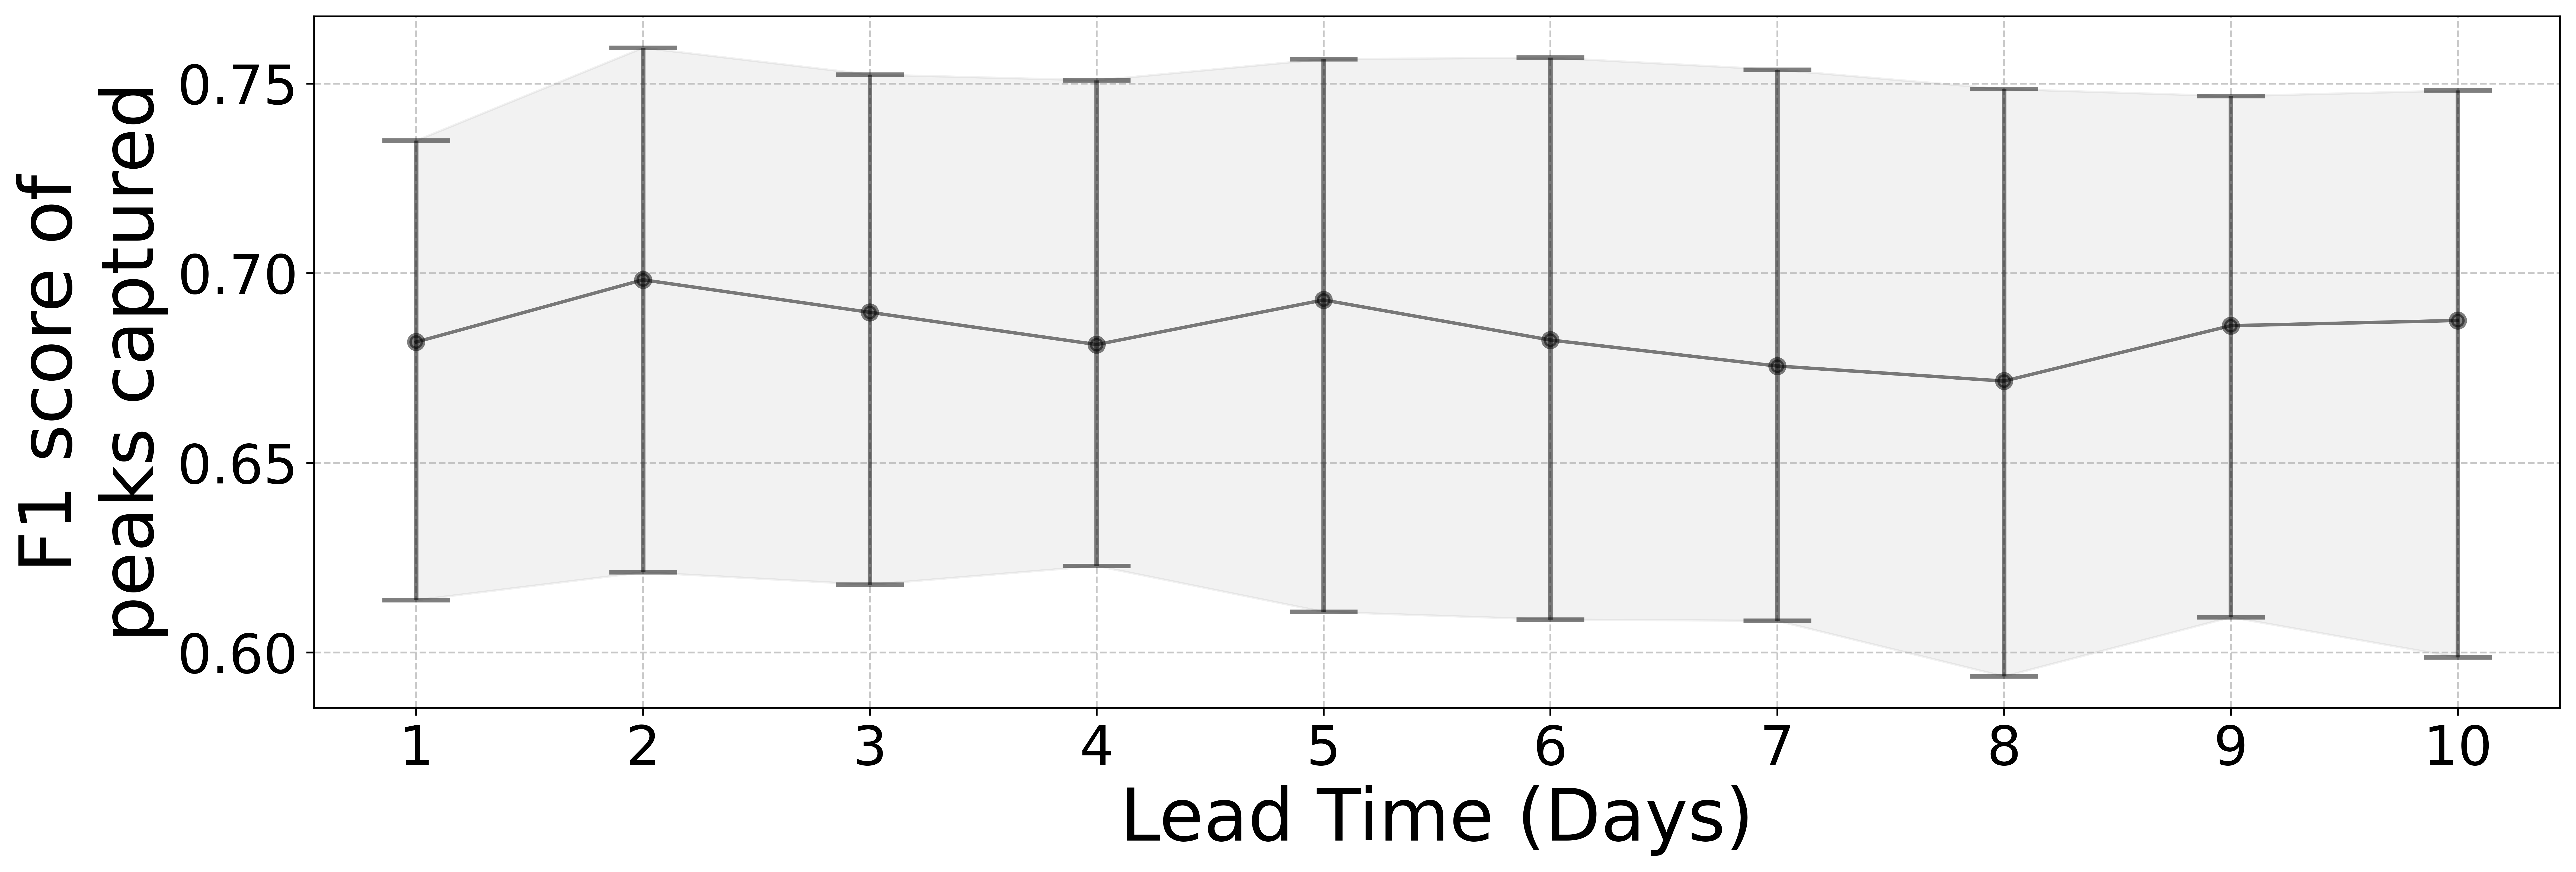

In [ ]:
ds_camelsus = xr.open_dataset(filepath(2, 'camelsus'))
ds_camelsind = xr.open_dataset(filepath(2, 'camelsind'))
ds_hysets = xr.open_dataset(filepath(2, 'hysets'))

datasets = {
    # 'CAMELS-US': ds_camelsus,
    'CAMELS-IND': ds_camelsind,
    # 'HYSETS': ds_hysets
}

colors = {
    'CAMELS-US': 'k',
    'CAMELS-IND': 'k',
    'HYSETS': 'k'
}

fig, ax = plt.subplots(figsize=(15, 5), dpi=600)

metric_name = 'F1_score'
if 'F1' in metric_name:
    min_max = [0, 1]
    metric_short = 'F1'
    metric_long = 'F1 score of \npeaks captured'
else:
    min_max = [-1, 1]
    metric_short = metric_name
    metric_long = metric_name

for key, ds in datasets.items():
    metric_values = ds[metric_name].values
    lead_times = ds.lead_time.values

    median_metric = np.nanmedian(metric_values, axis=1)
    q1 = np.nanpercentile(metric_values, 25, axis=1)
    q3 = np.nanpercentile(metric_values, 75, axis=1)

    lower_err = median_metric - q1
    upper_err = q3 - median_metric
    plt.fill_between(lead_times, q1, q3, color=colors[key], alpha=0.05)

    plt.errorbar(
        lead_times, 
        median_metric, 
        yerr=[lower_err, upper_err],
        fmt='-o', 
        capsize=15, 
        color=colors[key], 
        label=key, 
        alpha = 0.5, 
        markeredgewidth=2, 
        elinewidth=2
    )

plt.xlabel("Lead Time (Days)", fontsize=12)
plt.ylabel(metric_long, fontsize=12)
# plt.ylim(min_max)
# plt.legend(
#     bbox_to_anchor=(0.5, 1),
#     loc = 'lower center',
#     ncol=3,
#     # labelspacing=1.5
#     )
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(ticks=lead_times, labels=lead_times+1)
plt.tight_layout()

# Set the fontsize of labels and ticks
ax.tick_params(axis='both', which='major', labelsize=24)
ax.xaxis.label.set_size(32)
ax.yaxis.label.set_size(32)

plt.show()